# 1. Perprocess
## 1.1 parse XML
use BeautifulSoup to parse XML file, output with pandas dataframe "sentence, E#A, sentiment"

In [1]:
from bs4 import BeautifulSoup
import pandas as pd

def parseXML(path):
    with open(path) as xmldata:
        soup = BeautifulSoup(xmldata, "xml")
    # Create empty lists to store the extracted data
    sentence_ids = []
    texts = []
    categories = []
    polarities = []

    # Loop through the 'sentence' elements and extract the necessary information
    for sentence in soup.find_all('sentence'):
        sentence_ids.append(sentence['id'])
        texts.append(sentence.find('text').text)
        opinions = sentence.find('Opinions')
        if opinions is not None:
            s_categories = []
            s_polarities = []
            for opinion in opinions.find_all('Opinion'):
                s_categories.append(opinion['category'])
                s_polarities.append(opinion['polarity'])
            categories.append(s_categories)
            polarities.append(",".join(s_polarities))
        else:
            categories.append(["None"])
            polarities.append(None)

    # Create a pandas dataframe from the extracted data
    df = pd.DataFrame({'Sentence ID': sentence_ids,
                       'Text': texts,
                       'Categories': categories,
                       'Polarities': polarities})
    return df

In [2]:
Laptops_Train_p1 = parseXML("./data/Laptops_Train_p1.xml")
Laptops_Test_p1_gold = parseXML("./data/Laptops_Test_p1_gold.xml")

In [176]:
Laptops_Train_p1

,Sentence ID,Text,Categories,Polarities
0,79:0,Being a PC user my whole life....,[None],None
1,79:1,This computer is absolutely AMAZING!!!,[LAPTOP#GENERAL],positive
2,79:2,10 plus hours of battery...,[BATTERY#OPERATION_PERFORMANCE],positive
3,79:3,super fast processor and really nice graphics ...,"[CPU#OPERATION_PERFORMANCE, GRAPHICS#GENERAL]","positive,positive"
4,79:4,and plenty of storage with 250 gb(though I wil...,[HARD_DISC#DESIGN_FEATURES],positive
...,...,...,...,...
2495,B00KMRGF28_143_A2F0D5EV8ZOK44:1,It does what it advertises.,[LAPTOP#GENERAL],positive
2496,B00KMRGF28_143_A2F0D5EV8ZOK44:2,"Price is great, wish it didn't have Windows 8,...","[LAPTOP#PRICE, OS#GENERAL]","positive,negative"
2497,B00KMRGF28_143_A2F0D5EV8ZOK44:3,"I would recommend it, for anybody needing a re...",[LAPTOP#QUALITY],positive
2498,B00KMRGF28_302_A149BES2K4UIY1:0,I bought this for my daughter to use for schoo...,"[LAPTOP#OPERATION_PERFORMANCE, LAPTOP#DESIGN_F...","neutral,positive,positive"


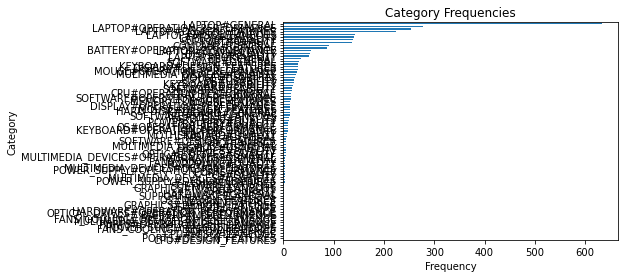

In [25]:
# Data analysis
import matplotlib.pyplot as plt

# Split categories and create new rows
df_copy = df.copy()
split_categories = df_copy['Category'].str.split(',')
df_copy = df_copy.assign(Category=split_categories).explode('Category')

# Get the unique categories and their frequencies
category_counts = df_copy['Category'].value_counts()
#top_categories = category_counts.head(50)

# Plot the frequencies in descending order
category_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Category Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.show()

## 1.2 tokenisation, (stopwords,punc removal), lemmatization

In [50]:
import nltk
##tokenisation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def tokenisation(data):
    tokenised_data = [word_tokenize(sentence) for sentence in data]
    return tokenised_data


def remove_stopwords(data):
    stopwords = stopwords.words('english')
    filtered_words = [[word for word in sentence if word.lower() not in stopwords] for sentence in data]
    return filter_words
#print(stopwords.words('english'))
def remove_punctuation(data):
    text = [[word for word in sentence if re.sub(r'[^\w\s]+', '', word).isalnum()] for sentence in data]
    return text

In [52]:
##lemmatization
from nltk import stem
def lemmatization(data):
    wnl = stem.WordNetLemmatizer()
    lematized = [[wnl.lemmatize(word) for word in sentence] for sentence in tokenised_data]
    return lematized

In [108]:
#data = df['Text'].values.tolist()
#data = tokenisation(data)
#data = remove_stopwords(data)
#data = remove_punctuation(data)
#data = lemmatization(data)
#data = [[word.lower() for word in sentence] for sentence in data]
#print(data)

[['Being', 'a', 'PC', 'user', 'my', 'whole', 'life', '....'], ['This', 'computer', 'is', 'absolutely', 'AMAZING', '!', '!', '!'], ['10', 'plus', 'hours', 'of', 'battery', '...'], ['super', 'fast', 'processor', 'and', 'really', 'nice', 'graphics', 'card', '..'], ['and', 'plenty', 'of', 'storage', 'with', '250', 'gb', '(', 'though', 'I', 'will', 'upgrade', 'this', 'and', 'the', 'ram', '..', ')'], ['This', 'computer', 'is', 'really', 'fast', 'and', 'I', "'m", 'shocked', 'as', 'to', 'how', 'easy', 'it', 'is', 'to', 'get', 'used', 'to', '...'], ['I', "'ve", 'only', 'had', 'mine', 'a', 'day', 'but', 'I', "'m", 'already', 'used', 'to', 'it', '...'], ['MACS', 'ARE', 'AMAZING', '!', '!', '!'], ['GET', 'THIS', 'COMPUTER', 'FOR', 'PORTABILITY', 'AND', 'FAST', 'PROCESSING', '!', '!', '!'], ['the', 'laptop', 'was', 'really', 'good', 'and', 'it', 'goes', 'really', 'fast', 'just', 'the', 'way', 'i', 'thought', 'it', 'would', 'of', 'run', '.'], ['i', 'would', 'really', 'recommend', 'to', 'any', 'perso

# 2. Model - Max Entropy Classifier with threshold t
## 2.1 Preprocess - PoS

In [77]:
# from nltk.tag import pos_tag
# pos_data = [pos_tag(sentence,tagset='universal') for sentence in data]
# print(pos_data)

In [82]:
def calculate_bow_around_verb(sentences):
    sentence_list = []
    verb_bow_list = []

    for sentence in sentences:
        verb_bow = []
        pos_tags = nltk.pos_tag(sentence)

        verbs = [word for word, pos in pos_tags if pos.startswith('VB')]

        if len(verbs) > 0:
            verb = verbs[0]
            verb_index = sentence.index(verb)

            for i in range(max(0, verb_index - 5), verb_index):
                if pos_tags[i][1].startswith('JJ') or pos_tags[i][1].startswith('RB') or pos_tags[i][1].startswith('NN'):
                    verb_bow.append(sentence[i])

            for i in range(verb_index + 1, min(verb_index + 6, len(sentence))):
                if pos_tags[i][1].startswith('JJ') or pos_tags[i][1].startswith('RB') or pos_tags[i][1].startswith('NN'):
                    verb_bow.append(sentence[i])

        sentence_list.append(sentence)
        verb_bow_list.append(verb_bow)

    df = pd.DataFrame({'Sentence': sentence_list, 'BoW around Verb': verb_bow_list})
    return df

In [84]:
def calculate_bow_at_end_of_sentence(sentences):
    sentence_list = []
    end_of_sentence_bow_list = []

    for sentence in sentences:
        end_of_sentence_bow = []
        pos_tags = nltk.pos_tag(sentence)

        for i in range(len(pos_tags)-1, max(len(pos_tags)-6, -1), -1):
            if pos_tags[i][1].startswith('JJ') or pos_tags[i][1].startswith('RB'):
                end_of_sentence_bow.append(sentence[i])

        sentence_list.append(sentence)
        end_of_sentence_bow_list.append(end_of_sentence_bow)

    df = pd.DataFrame({'Sentence': sentence_list, 'BoW at End of Sentence': end_of_sentence_bow_list})
    return df

In [83]:
calculate_bow_around_verb(data)

,Sentence,BoW around Verb
0,"[Being, a, PC, user, my, whole, life, ....]","[PC, user, whole]"
1,"[This, computer, is, absolutely, AMAZING, !, !...","[computer, absolutely, AMAZING]"
2,"[10, plus, hours, of, battery, ...]",[]
3,"[super, fast, processor, and, really, nice, gr...","[processor, really, nice, graphics, ..]"
4,"[and, plenty, of, storage, with, 250, gb, (, t...","[gb, ram, ..]"
...,...,...
2495,"[It, does, what, it, advertises, .]",[]
2496,"[Price, is, great, ,, wish, it, did, n't, have...","[Price, great, wish]"
2497,"[I, would, recommend, it, ,, for, anybody, nee...",[anybody]
2498,"[I, bought, this, for, my, daughter, to, use, ...",[daughter]


In [85]:
calculate_bow_at_end_of_sentence(data)


,Sentence,BoW at End of Sentence
0,"[Being, a, PC, user, my, whole, life, ....]",[whole]
1,"[This, computer, is, absolutely, AMAZING, !, !...","[AMAZING, absolutely]"
2,"[10, plus, hours, of, battery, ...]",[]
3,"[super, fast, processor, and, really, nice, gr...","[nice, really]"
4,"[and, plenty, of, storage, with, 250, gb, (, t...",[]
...,...,...
2495,"[It, does, what, it, advertises, .]",[]
2496,"[Price, is, great, ,, wish, it, did, n't, have...",[]
2497,"[I, would, recommend, it, ,, for, anybody, nee...","[simple, reliable]"
2498,"[I, bought, this, for, my, daughter, to, use, ...","[light, very]"


In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
def caculate_TFIDF(data):
    # Create an instance of TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the sentences into numerical representation using TF-IDF
    numerical_representation = vectorizer.fit_transform(sentences)

    # Convert the numerical representation to a pandas DataFrame
    df_numerical_representation = pd.DataFrame(numerical_representation.toarray(), columns=vectorizer.get_feature_names())
    return df_numerical_representation

In [91]:
# Convert the tokenized sentences back into sentences
sentences = [" ".join(tokens) for tokens in data]
caculate_TFIDF(data)

,00,04,07,09,10,100,1000,1024,1080p,10th,...,ymmv,yo,you,young,your,yourself,youtube,z0j80001,zero,zone
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.495658,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Example dataset with text and corresponding labels
pdata = pd.DataFrame({'text': [" ".join(tokens) for tokens in data],
                     'label': df['Categories'].tolist()})

# Convert label column to list of label lists
label_lists = pdata['label']

# Split the data into training and testing sets
train_data, test_data = train_test_split(pdata, test_size=0.2, random_state=42)

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()
# Fit and transform the training data into TF-IDF features
X_train = vectorizer.fit_transform(train_data['text'])
# Transform the testing data into TF-IDF features
X_test = vectorizer.transform(test_data['text'])

# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transformclfthe training labels into binary array
y_train = mlb.fit_transform(train_data['label'])
# Transform the testing labels into binary array
y_test = mlb.transform(test_data['label'])

# Create an instance of LogisticRegression
clf = LogisticRegression()
y_pred = np.zeros((500, 78))
# Iterate through each label and train a separate binary classifier
for i in range(y_train.shape[1]):
    label = mlb.classes_[i]
    print("Training classifier for label:", label)
    # Fit the model on the training data for the current label
    clf.fit(X_train, y_train[:, i])
    # Predict the probabilities of the current label for the testing data
    y_pred_prob = clf.predict_proba(X_test)[:, 1] # Use probabilities of positive class (1)

    # Set the threshold for category assignment
    threshold = 0.2

    # Generate predicted labels based on threshold
    y_pred_labels = np.where(y_pred_prob >= threshold, 1, 0)

    # Add predicted labels to the corresponding column in the binary label array
    y_pred[:, i] = y_pred_labels.tolist()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", report)

/home/xinpeng/APP/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['CPU#MISCELLANEOUS', 'FANS_COOLING#DESIGN_FEATURES', 'MULTIMEDIA_DEVICES#MISCELLANEOUS', 'WARRANTY#PRICE'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Training classifier for label: BATTERY#MISCELLANEOUS
Training classifier for label: BATTERY#OPERATION_PERFORMANCE
Training classifier for label: BATTERY#QUALITY
Training classifier for label: COMPANY#GENERAL
Training classifier for label: CPU#DESIGN_FEATURES
Training classifier for label: CPU#OPERATION_PERFORMANCE
Training classifier for label: CPU#QUALITY
Training classifier for label: DISPLAY#DESIGN_FEATURES
Training classifier for label: DISPLAY#GENERAL
Training classifier for label: DISPLAY#OPERATION_PERFORMANCE
Training classifier for label: DISPLAY#QUALITY
Training classifier for label: DISPLAY#USABILITY
Training classifier for label: FANS_COOLING#OPERATION_PERFORMANCE
Training classifier for label: FANS_COOLING#QUALITY
Training classifier for label: GRAPHICS#DESIGN_FEATURES
Training classifier for label: GRAPHICS#GENERAL
Training classifier for label: GRAPHICS#MISCELLANEOUS
Training classifier for label: GRAPHICS#QUALITY
Training classifier for label: HARDWARE#GENERAL
Training c

In [139]:
y_train.shape[1]

78

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report

train = pd.DataFrame({'text': Laptops_Train_p1['Text'],
                      'label': Laptops_Train_p1['Categories']})
test = pd.DataFrame({'text': Laptops_Test_p1_gold['Text'],
                     'label': Laptops_Test_p1_gold['Categories']})

def custom_tokenizer(text):
    # Tokenize the text using NLTK's word_tokenize function
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if re.sub(r'[^\w\s]+', '', word).isalnum()]
    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]   
    return tokens

def features_unigram(df, df_t):    
    # Create a CountVectorizer instance to compute unigram counts
    count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer,max_features=1000)
    # Fit and transform the sentences to obtain the unigram count features
    count_matrix = count_vectorizer.fit_transform(df['text'])
    count_matrix_t = count_vectorizer.transform(df_t['text'])
    # Convert the count matrix to a dataframe with appropriate column names
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names())
    count_df_t = pd.DataFrame(count_matrix_t.toarray(), columns=count_vectorizer.get_feature_names())
    return count_df, count_df_t

def feature_Tfidf(df, df_t):
    # Create a TfidfVectorizer instance to compute TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    # Fit and transform the sentences to obtain the TF-IDF features
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
    tfidf_matrix_t = tfidf_vectorizer.transform(df_t['text'])
    # Convert the TF-IDF matrix to a dataframe with appropriate column names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
    tfidf_df_t = pd.DataFrame(tfidf_matrix_t.toarray(), columns=tfidf_vectorizer.get_feature_names())
    return tfidf_df, tfidf_df_t

# Concatenate the original dataframe with the unigram count dataframe and the TF-IDF dataframe
unigram_train, unigram_test = features_unigram(train, test)
tfidf_train, tfidf_test = feature_Tfidf(train, test)
x_train = pd.concat([unigram_train, tfidf_train], axis=1)
x_test = pd.concat([unigram_test, tfidf_test], axis=1)


# Convert the labels into binary arrays
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train['label'])
y_test = mlb.transform(test['label'])
# Create a dataframe for the binary label arrays
y_train = pd.DataFrame(y, columns=mlb.classes_)
y_test = pd.DataFrame(y_test, columns=mlb.classes_)

/home/xinpeng/APP/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['BATTERY#DESIGN_FEATURES', 'CPU#GENERAL', 'HARD_DISC#GENERAL', 'HARD_DISC#OPERATION_PERFORMANCE', 'OPTICAL_DRIVES#DESIGN_FEATURES', 'OPTICAL_DRIVES#GENERAL', 'POWER_SUPPLY#GENERAL'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [18]:
# Create an instance of LogisticRegression
clf = LogisticRegression(max_iter=1000)
y_pred = np.zeros(y_test.shape)
# Iterate through each label and train a separate binary classifier
for i in range(y_train.shape[1]):
    label = mlb.classes_[i]
    print("Training classifier for label:", label)
    # Fit the model on the training data for the current label
    clf.fit(x_train, y_train.iloc[:, i])
    # Predict the probabilities of the current label for the testing data
    y_pred_prob = clf.predict_proba(x_test)[:, 1] # Use probabilities of positive class (1)

    # Set the threshold for category assignment
    threshold = 0.2

    # Generate predicted labels based on threshold
    y_pred_labels = np.where(y_pred_prob >= threshold, 1, 0)

    # Add predicted labels to the corresponding column in the binary label array
    y_pred[:, i] = y_pred_labels.tolist()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", report)

Accuracy: 0.16336633663366337
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         0
           1       0.53      0.84      0.65        19
           2       0.00      0.00      0.00         5
           3       0.46      0.29      0.35        38
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         2
           7       1.00      1.00      1.00         0
           8       0.20      0.08      0.11        13
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         8
          11       0.60      0.45      0.51        20
          12       1.00      0.00      0.00         5
          13       1.00      1.00      1.00         0
          14       1.00      0.00      0.00         2
          15       1.00      1.00      1.00         0
          16       1.00    